### Import Packages:

In [1]:
# import packages
import modin.pandas as md
import pandas as pd
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as wb
import numpy as np
import matplotlib.pyplot as plt
from functions.functions import *
from copy import deepcopy
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import and Clean Up Data:

In [2]:
# monthly stock file location
file_path = 'data/crsp_monthly_file.csv'

# import and clean data
data = import_clean_data(path=file_path)

# compute volumes, stdevs, correls, and betas
data = compute_price_volume(df=data)
data = compute_mkt_stock_volatilities(df=data)
print('computing rolling stock/market correlations...')
data['COR'] = data.groupby('PERMNO').apply(compute_rolling_correlations)
print('computing stock/market betas...')
data['BETA'] = data.groupby('PERMNO').apply(compute_betas)
data = compute_adjusted_betas(df=data)

# drop any rows for which we don't have a beta or return
data = data.dropna(how='any',subset=['BETA','RET'])

# only keep stocks that meet a certain liquidity requirement
daily_liquidity_req = 50000
data = data[data['ADV'] > daily_liquidity_req]

# select starting date
start_date = '1980-12-31'
data = data[data['date'] > start_date]

# compute quantiles
quantiles = 10
print('computing quantiles...')
data['QTLS'] = data.groupby(['date'])['BETA'].transform(lambda x: pd.qcut(x,quantiles,labels=False)+1)

importing and cleaning data...
computing average daily volumes...
computing market/stock volatilities...
computing rolling stock/market correlations...
computing stock/market betas...
computing adjusted betas...
computing quantiles...


### Reduce Dataset, Compute Holding Periods for Next Month, Merge Holding Periods Back on Return Data:

In [3]:
# just take the top and bottom quantiles, this speeds up future computations
reduced_data = compute_reduced_dataset(df=data,quantiles=quantiles,QTLS='QTLS',top_mktcap=False,no_companies_per_quantile=500)

# compute returns on portfolio that holds the stocks for the next month
holding_periods = compute_holding_periods(df=data,QTLS='QTLS')

# also scales quantile portfolio weights so that their Beta relative to the market approximates 1
port, portfolio = merge_holding_periods_on_returns(data=data,holding_periods=holding_periods,QTLS='QTLS')

reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
scaling weights according to betas...


### Pivot Returns and Set Up Return Plots:

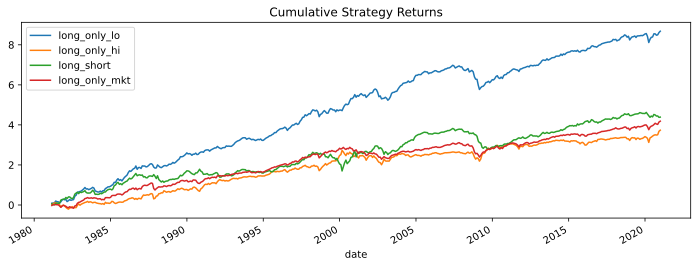

In [4]:
# pivot portfolio returns for plotting
strategy_pivot = port.pivot(index='date', columns='QTLS', values='RET').add_prefix('quantile ').rename(columns={'quantile 1': 'low',f'quantile {quantiles}': 'high'}).fillna(0)

# compute low-beta portfolio less high-beta portfolio returns
strategy_pivot['low-high'] = strategy_pivot.low - strategy_pivot.high

# add value-weighted market returns
mkt = data.drop_duplicates(subset=['date','vwretd']).sort_values(by=['date'])[['date','vwretd']].set_index('date')
mkt['long_only_mkt'] = np.log(1 + mkt).cumsum()
mkt = mkt[mkt.index >= strategy_pivot.index[0]]

# compute strategy cumulative returns
strategy_pivot['long_only_lo'] = np.log(1 + strategy_pivot.low).cumsum()
strategy_pivot['long_only_hi'] = np.log(1 + strategy_pivot.high).cumsum()
strategy_pivot['long_short'] = np.log(1 + (strategy_pivot.low - strategy_pivot.high)).cumsum()

# compute plots for each strategy
plt.figure(figsize=(12,4))
strategy_pivot['long_only_lo'].plot()
strategy_pivot['long_only_hi'].plot()
strategy_pivot['long_short'].plot()
mkt['long_only_mkt'].plot()
plt.title('Cumulative Strategy Returns')
plt.legend()
plt.savefig('strat_ret')
plt.show()

### Confirm That Long/Short End of Portfolio Maintain Approximate Beta of 1:

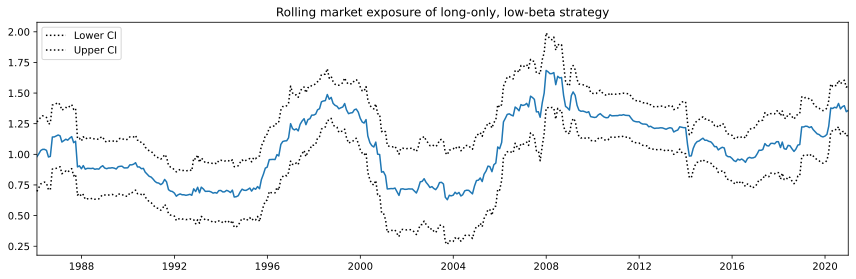

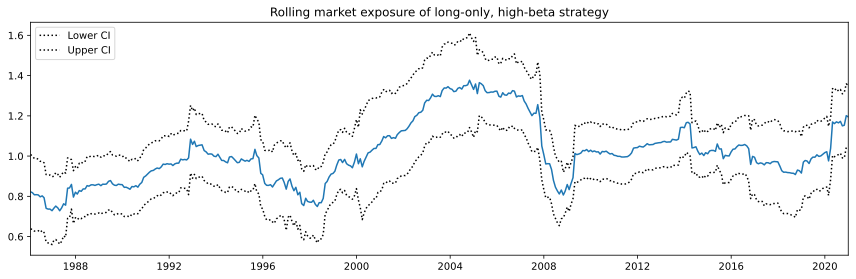

In [8]:
levers = ['low','high']
i = 0
for each in levers:
    # set up rolling regression
    Y = strategy_pivot[each]
    X = sm.add_constant(mkt['vwretd'])
    est = RollingOLS(Y,X,window=60,min_nobs=60,expanding=True).fit()
    leverage_betas = est.params.shift(1)[['vwretd']]

    # plot market exposure coefficients
    est.plot_recursive_coefficient(variables=['vwretd'],figsize=(12,4))
    plt.title(f'Rolling market exposure of long-only, {each}-beta strategy')
    plt.show()

### Pull in Fama French Data:

In [9]:
# issue start date and end date
startdate = strategy_pivot.index[0]
enddate = strategy_pivot.index[-1]

# pull famafrench factors and format
factor_returns = factor_returns = wb.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench',start=startdate,end=enddate)[0]/100
factor_returns.index = strategy_pivot.index

### Run CAPM Regression:

In [10]:
Y = strategy_pivot['low-high'] - factor_returns['RF'].values
X = sm.add_constant(mkt['vwretd'] - factor_returns['RF'].values)
est = sm.OLS(Y,X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               low-high   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04537
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.831
Time:                        09:48:13   Log-Likelihood:                 657.48
No. Observations:                 479   AIC:                            -1311.
Df Residuals:                     477   BIC:                            -1303.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.003      2.747      0.0

### Run FF5F Regression:

In [11]:
Y = strategy_pivot['low-high'] - factor_returns['RF'].values
X = sm.add_constant(factor_returns[['Mkt-RF','SMB','HML','RMW','CMA']])
est = sm.OLS(Y,X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               low-high   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     39.76
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           4.16e-34
Time:                        09:48:15   Log-Likelihood:                 741.48
No. Observations:                 479   AIC:                            -1471.
Df Residuals:                     473   BIC:                            -1446.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.621      0.5

### Compute and Plot Rolling 5 Year CAPM Alpha:

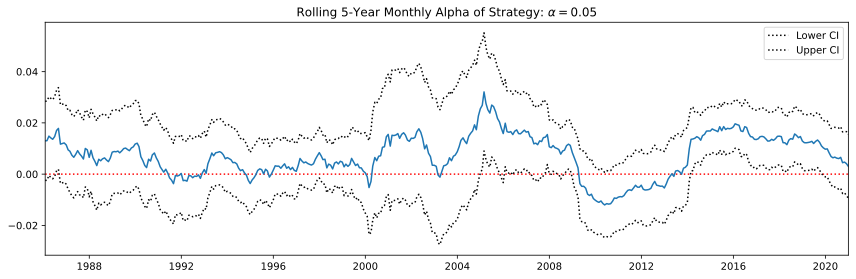

In [9]:
Y = strategy_pivot['low-high'] - factor_returns['RF'].values
X = sm.add_constant(mkt['vwretd'] - factor_returns['RF'].values)
est = RollingOLS(Y,X,window=60,min_nobs=60,expanding=True).fit()
est.plot_recursive_coefficient(variables=['const'],figsize=(12,4))
plt.hlines(0,est.params.dropna(how='all').index[0],est.params.dropna(how='all').index[-1],colors='r',linestyles=':')
plt.title(r'Rolling 5-Year Monthly Alpha of Strategy: $\alpha = 0.05$')
plt.legend()
plt.show()

### Robustness Checks

#### Returns by Quantile

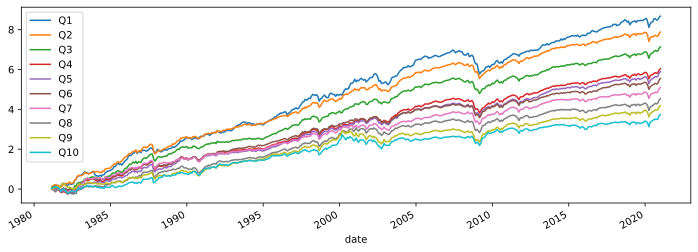

In [13]:
# compute plots for each quantile
strategy_pivot['Q1'] = np.log(1 + strategy_pivot['low']).cumsum()
strategy_pivot['Q2'] = np.log(1 + strategy_pivot['quantile 2']).cumsum()
strategy_pivot['Q3'] = np.log(1 + strategy_pivot['quantile 3']).cumsum()
strategy_pivot['Q4'] = np.log(1 + strategy_pivot['quantile 4']).cumsum()
strategy_pivot['Q5'] = np.log(1 + strategy_pivot['quantile 5']).cumsum()
strategy_pivot['Q6'] = np.log(1 + strategy_pivot['quantile 6']).cumsum()
strategy_pivot['Q7'] = np.log(1 + strategy_pivot['quantile 7']).cumsum()
strategy_pivot['Q8'] = np.log(1 + strategy_pivot['quantile 8']).cumsum()
strategy_pivot['Q9'] = np.log(1 + strategy_pivot['quantile 9']).cumsum()
strategy_pivot['Q10'] = np.log(1 + strategy_pivot['high']).cumsum()

plt.figure(figsize=(12,4))
strategy_pivot['Q1'].plot()
strategy_pivot['Q2'].plot()
strategy_pivot['Q3'].plot()
strategy_pivot['Q4'].plot()
strategy_pivot['Q5'].plot()
strategy_pivot['Q6'].plot()
strategy_pivot['Q7'].plot()
strategy_pivot['Q8'].plot()
strategy_pivot['Q9'].plot()
strategy_pivot['Q10'].plot()

# plt.title('Cumulative Returns by Quantile')
plt.legend()
plt.savefig('ret_by_Q.png')
plt.show()

#### Seasonality Checks

In [34]:
def plot_seasonality(df, ret):
    plt.figure(figsize=(12, 5))
    df = pd.DataFrame(df).reset_index()
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df = df.pivot(index='month', columns='year', values=ret)
    ax = sns.heatmap(df,linewidths=.2)
    plt.savefig(ret+'_seasonal.png')
    plt.show()

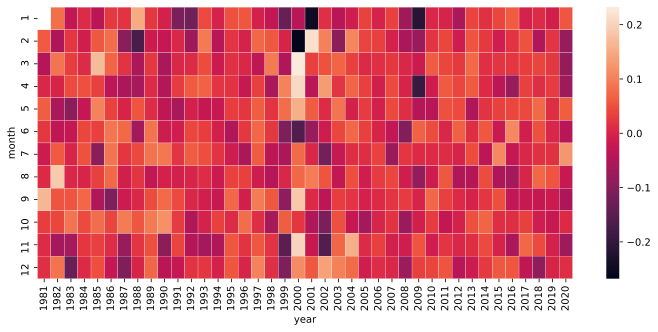

In [35]:
plot_seasonality(strategy_pivot['low-high'], 'low-high')

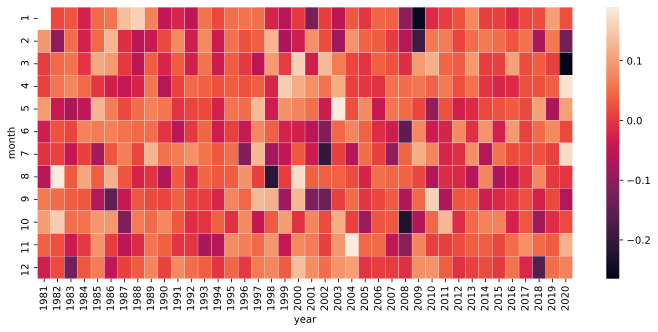

In [36]:
plot_seasonality(strategy_pivot['low'], 'low')

#### Lead-Lag

In [52]:
lead_lag_dict = {}
# def gen_lead_lag(df):
for i in range(-3,4):
    data['ll_Q'] = data.sort_values('date').groupby('PERMNO')['QTLS'].shift(i)
    data = data[data.ll_Q.notnull()]
    # just take the top and bottom quantiles, this speeds up future computations
    reduced_data = compute_reduced_dataset(df=data,quantiles=quantiles,QTLS='ll_Q',top_mktcap=False,no_companies_per_quantile=500)
    # compute returns on portfolio that holds the stocks for the next month
    holding_periods = compute_holding_periods(df=data,QTLS='ll_Q')
    # also scales quantile portfolio weights so that their Beta relative to the market approximates 1
    port, portfolio = merge_holding_periods_on_returns(data=data,holding_periods=holding_periods,QTLS='ll_Q')

    strategy_pivot = port.pivot(index='date', columns='ll_Q', values='RET').add_prefix('quantile ').rename(columns={'quantile 1.0': 'low', 'quantile 10.0': 'high', 'quantile 1': 'low', 'quantile 10': 'high'}).fillna(0)
    print(strategy_pivot.columns)
    strategy_pivot['low-high'] = strategy_pivot.low - strategy_pivot.high

    avg_return = strategy_pivot['low-high'].mean()
    lead_lag_dict[i] = avg_return

reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
scaling weights according to betas...
Index(['low', 'quantile 2.0', 'quantile 3.0', 'quantile 4.0', 'quantile 5.0',
       'quantile 6.0', 'quantile 7.0', 'quantile 8.0', 'quantile 9.0', 'high'],
      dtype='object', name='ll_Q')
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
scaling weights according to betas...
Index(['low', 'quantile 2.0', 'quantile 3.0', 'quantile 4.0', 'quantile 5.0',
       'quantile 6.0', 'quantile 7.0', 'quantile 8.0', 'quantile 9.0', 'high'],
      dtype='object', name='ll_Q')
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
scaling weights according to betas...
Index(['low', 'quantile 2.0', 'quantile 3

In [53]:
lead_lag = pd.DataFrame(data=lead_lag_dict.items(), columns=['Lag','Average Return'])

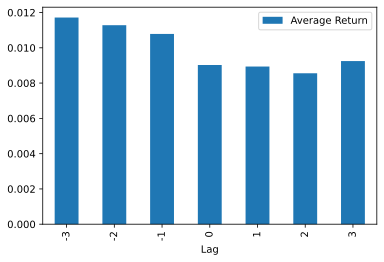

In [54]:
lead_lag.plot.bar(x='Lag',y='Average Return')
plt.show()

### Rolling Sharpe

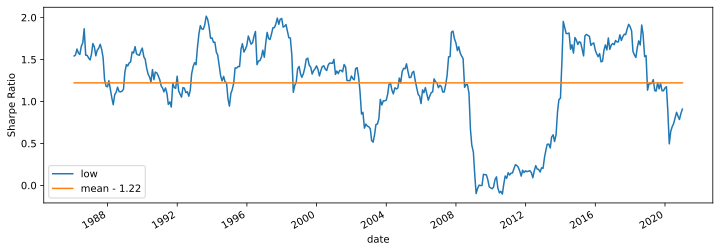

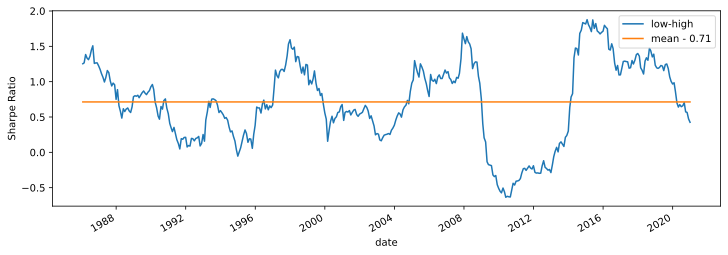

In [13]:
# 5 Year Rolling Sharpe Ratio for Long Only and Long/Short Configuration
configs = ['low','low-high']

for each in configs:
    means = (strategy_pivot[[each]].rolling(window=60,min_periods=60).mean() * 12).dropna()
    stds = (strategy_pivot[[each]].rolling(window=60,min_periods=60).std() * np.sqrt(12)).dropna()
    sharpes = means/stds
    sharpes['average'] = np.full(sharpes.shape,fill_value=sharpes.mean())
    sharpes.plot(figsize=(12,4))
    plt.ylabel('Sharpe Ratio')
    plt.legend([each,f'mean - {round(sharpes.average.mean(),ndigits=2)}'])
    plt.savefig(each+'_sharpe.png')
    plt.show()